### Imports

In [1]:
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.colors import LogNorm
import IPython.display as pyDisplay
import matplotlib.transforms as transforms
import scipy.special as sciSpec
import subprocess
import tfs
#import xline as xl
#import xobjects as xo
#import xtrack as xt
#import xpart as xp

from cpymad.madx import Madx


# Utilities

In [2]:

##############################################################
def vecNorm(vec):
    return np.sqrt(vec[0]**2 + vec[1]**2)
##############################################################


##############################################################
def getMultiCoeff(I,L,pos,nmax=1):
    # To be redefined from cst list
    mu0 = 4e-7*np.pi 
    
    # compute the integrated normal and skew components
    # Note: mistake in Axel's thesis, the n! not consistent with definition of fields
    # Note: mistake in Axel's thesis, sign of integrated component not correct. Refer to S.F. paper.
    n = np.arange(nmax+1)
    integratedComp = -mu0*(I*L)*sciSpec.factorial(n)/(2*np.pi)/(pos[0]+1j*pos[1])**(n+1)
    
    kn,sn = np.real(integratedComp),np.imag(integratedComp)
    
    return kn,sn
##############################################################


##############################################################
def makeMadWire(I,L,pos,p0c,at = 0,nmax=20,mask=None,name = 'multipole_wire'):
    
    kn,sn = getMultiCoeff(I,L,pos,nmax=nmax)
    
    # To be redefined from cst list
    c = 299792458 
    
    # mask -> boolean array used to choose only specific orders of the multipole expansion
    if mask is not None:
        kn[np.invert(mask)] = 0
        sn[np.invert(mask)] = 0
        
    # p0 -> momentum in eV/c
    KNL = (L*kn/(p0c/c))
    KSL = (L*sn/(p0c/c))
    
    # computing HKICK and VKICK from dipole component:
    #-----------------------------------
    # complexKicks =  DPx - iDPy
    complexKick = -(KNL[0]/L + 1j*KSL[0]/L)
    HKICK,VKICK = np.real(complexKick),-np.imag(complexKick)
    #-----------------------------------

    
    def_1of2 = f'class_{name}_1of2 : MULTIPOLE,KNL = {{0,{",".join(KNL[1:].astype(str))}}},KSL = {{0,{",".join(KSL[1:].astype(str))}}};'
    def_2of2 = f'class_{name}_2of2 : KICKER, L=0, HKICK={HKICK}, VKICK={VKICK}, TILT=real;'
    
    
    thisWire = pd.DataFrame({'mode':['install','install'],
                             'name':[f'{name}_1of2',f'{name}_2of2'],
                             'at': [at,at],
                             'definition':[def_1of2 ,def_2of2 ]}) 
        
    return thisWire
##############################################################

##############################################################
def get_tracking_string(particleData):
    '''
    Creates tracking string from particle initial coordinates.
    ----------------------------------------------------------
    Input:
        particleData: pd.Series/dict containing canonical or action-angle coordinates
    Output:
        trackingCmd: formated string "start,x=0,px=0,y=0,py=0,t=0,pt=0,fx=0,phix=0,fy=0,phiy=0,ft=0,phit=0;"
        (Default value is 0 for all coordinates)
    '''

    coordinates = ['x','px','y' ,'py' ,'t' ,'pt', 'fx','phix','fy','phiy','ft','phit']
    trackingCmd = ['start']
    trackingCmd += [f'{coord}={particleData.get(coord,0)}' for coord in coordinates]
    trackingCmd = ','.join(trackingCmd)
    return trackingCmd
##############################################################


##############################################################
def MADTrackParticles(madInstance,coordinates,NTurns = 1,saveFile = None):

 
    trackingCmds = coordinates.apply(get_tracking_string,axis=1)
    trackingCmds = ';\n'.join(trackingCmds)

    #obsPoints = [name for name in list(madInstance.elements) if 'marker' in name]
    #observationCmds = ';\n'.join([f'observe, place={name}' for name in obsPoints])
    observationCmds = ''
    
    saveCmd = ''
    if saveFile is not None:
        saveCmd = f'WRITE, TABLE=trackone, FILE={saveFile}'
    
    madCall = ( f"track,dump,onepass, onetable = true,file=trackone.trk;\n"
                f"\n"
                f"!{40*'-'}\n"
                f"{trackingCmds};\n"
                f"!{observationCmds};\n"
                f"!{40*'-'}\n"
                f"\n"
                f"run,turns={NTurns};\n"
                f"endtrack;\n"
                f"{saveCmd};")

    madInstance.input(madCall)
##############################################################


##############################################################
def seqedit(sequence,editing, makeThin = False):
    
    output = ''
    if makeThin:
        output = f'''
        use, sequence = {sequence};
        makethin,sequence = {sequence};'''
    
    # install,element = multipole_wire_1of2,class=_multipole_wire_1of2 ,at = 0.5
    elementsEntry = '\n'.join([f'{row["mode"]},element = {row["name"]},class={row["definition"].split(":")[0]},at = {row["at"]};' for _,row in editing.iterrows()])
    definitionEntry = '\n'.join(editing['definition'])
                               
    
    output += f'''
    
        {definitionEntry}
    
        use, sequence = {sequence};
        SEQEDIT, SEQUENCE={sequence};
            FLATTEN;
            {elementsEntry}
            FLATTEN;
        ENDEDIT;

        use, sequence = {sequence};
    '''
    
    if makeThin:
        output += f'''
        use, sequence = {sequence};
        makethin,sequence = {sequence};'''
    
                               
    return output
##############################################################
                               
                               
                            
##############################################################
madSetup = '''
        !-------------------
        ! Defining sequence
        !-------------------
        
        K_Qf = {K_Q};
        K_Qd = -{K_Q};
        
        {sequence}:sequence, refer = center, L={L_cell};
        !------------------------        
        !------------------------
        endsequence;


        !-------------------
        ! Defining Beam 
        !-------------------
        beam,   particle = proton, 
                energy   = {Energy},
                sige     = 1.1e-4, 
                exn      = {Emittance_n},
                eyn      = {Emittance_n},
                bcurrent = {BCurrent};

        !-------------------
        ! Twiss and MakeThin
        !-------------------
        use, sequence = {sequence}; 
        makethin,sequence = {sequence};

        '''
##############################################################


##############################################################

madMatch = '''
    use, period = {sequence};
    match;

    vary, name=K_Qf,step=.001,UPPER=5,LOWER=-5;
    vary, name=K_Qd,step=.001,UPPER=5,LOWER=-5;
    
    constraint,range=#end,mux={mux},muy={muy};

    lmdif,calls=100;
    endmatch;


    title, 'Twiss';
    twiss;
'''
##############################################################
                               
                               
                               
                               
##############################################################
                               

def cart2pol(x, y):
    rho = np.sqrt(x**2 + y**2)
    phi = np.arctan2(y, x)
    return (rho, phi)

class wire():
    def __init__(self,x,y,I,L):
        self.x,self.y = x,y
        self.r0,self.theta0 = cart2pol(self.x,self.y)
        self.I = I
        self.L = L
        
    def getField(self,xObs,yObs,order=20):
        self.order = order
        mu0 = 4e-7*np.pi 
        Bref = mu0*self.I/(2*np.pi*self.r0)
        
        
        complexFields = np.zeros(np.shape(xObs)).astype('complex128')
        for n in np.arange(1,order+1):
            complexFields += Bref*(-np.exp(-1j*n*self.theta0))*(xObs/self.r0+1j*yObs/self.r0)**(n-1)
        
        # complexFields =  By + iBx
        # return Bx,By
        return np.imag(complexFields),np.real(complexFields)
    
    
    def getKick(self,xObs,yObs,p0c,order=20):
        self.order = order
        mu0 = 4e-7*np.pi
        c = 299792458
        
        if order != np.inf:
            kn,sn = getMultiCoeff(self.I,self.L,[self.x,self.y],nmax=order)

            KNL = kn/(p0c/c)
            SNL = sn/(p0c/c)

            complexKicks = np.zeros(np.shape(xObs)).astype('complex128')
            for n,KNL_n,SNL_n in zip(np.arange(order+1),KNL,SNL):
                complexKicks += -(KNL_n + 1j*SNL_n)*(xObs+1j*yObs)**(n)/sciSpec.factorial(n)

            # complexKicks =  DPx - iDPy
            # return DPx,DPy
            return np.real(complexKicks),-np.imag(complexKicks)
        else:
            
            q =  1 # when p0c given in eV
            
            rVec = vecNorm([self.x-xObs,self.y-yObs])
            amplitude = q*self.L*(mu0*self.I/(2*np.pi*rVec))/(p0c/c)
            
            Px = amplitude*(self.x-xObs)/rVec
            Py = amplitude*(self.y-yObs)/rVec
            
            return Px,Py
            
    
    def plotWireLocation(self,scaling=1,ax = None):
        if ax is None:
            ax = plt.gca()
            
        ax.plot([scaling*self.x],[scaling*self.y],'o',color='C1',fillstyle = 'none',markersize=12)
        if self.I>0:
            ax.plot([scaling*self.x],[scaling*self.y],'.',color='C1',markersize=8)                  
        else:
            ax.plot([scaling*self.x],[scaling*self.y],'x',color='C1',markersize=8)
        #ax.axvline(self.r0,color='k',linestyle='--')
        #ax.axvline(-self.r0,color='k',linestyle='--')
                            
##############################################################
                               
                               
                               
##############################################################
def plotVecField(X,Y,vecX,vecY,rValid=np.infty,scaling = 1,color = [],colorLim = [],colorLabel = '',mode='streamplot',nSeeds = 0,seed_points = None,seedAngle = 0,arrowColor = 'k',arrowSize = 1,norm = None,quiverDensity = 1):
 
    norm = LogNorm() if norm == 'log' else None
    currentExtent =  [scaling*np.min(X),scaling*np.max(X),scaling*np.min(Y),scaling*np.max(Y)]
    
    invalidRegion = ((X)**2 + (Y)**2 > (rValid)**2)
    copyX = X.copy()
    copyY = Y.copy()
    X[invalidRegion] = np.nan
    Y[invalidRegion] = np.nan
    vecX[invalidRegion] = np.nan
    vecY[invalidRegion] = np.nan
    
    currentNorm = vecNorm([vecX,vecY])

    if len(color)==0:
        colorLim = [np.min(currentNorm), np.max(currentNorm)] if len(colorLim) == 0 else colorLim
        plt.imshow(currentNorm, extent = currentExtent,origin='lower',norm=norm,vmin=colorLim[0], vmax=colorLim[1])
    else:
        colorLim = [np.min(color), np.max(color)] if len(colorLim) == 0 else colorLim
        plt.imshow(color, extent = currentExtent,origin='lower',norm=norm,vmin=colorLim[0], vmax=colorLim[1])
    plt.colorbar(label = colorLabel)

    if mode == 'quiver':
        density = int(10/quiverDensity)
        plt.quiver(scaling*X[::density,::density],scaling*Y[::density,::density], vecX[::density,::density]/currentNorm[::density,::density],vecY[::density,::density]/currentNorm[::density,::density])#,width = maxArrowSize *0.05*scaling*(np.max(X)-np.min(X)),color = arrowColor)
    elif mode == 'streamplot':
        if seed_points is None:
            rVec = np.linspace(-rValid,rValid,nSeeds)
            seed_points = np.array([rVec*np.cos(seedAngle),rVec*np.sin(seedAngle)])
            
        plt.streamplot(scaling*copyX,scaling*copyY,vecX,vecY,density = 20,linewidth=arrowSize,color = arrowColor,start_points=scaling*seed_points.T)
##############################################################
                               
                               
                               
                               
##############################################################
                            
def plotBeamDirection(x,y,name= 'Beam 1',color = 'b',direction = '+',fontsize = 15,ax = None):
    if ax is None:
        ax = plt.gca()

    props = dict(boxstyle='round', facecolor='white', alpha=0.5)

    ax.text(x,y,'    '+name, 
            transform=ax.transAxes, 
            fontsize=fontsize,
            color=color,
            verticalalignment='center',
            horizontalalignment='left', 
            bbox=props)

    boxZorder = [TOject.zorder for TOject in ax.texts if name in TOject.get_text()][0]
    xOffset = 0.02
    ax.plot(x+xOffset,y,'o',transform = ax.transAxes,color=color,fillstyle = 'none',markersize=12,zorder = boxZorder+1)
    if direction == '+':
        ax.plot(x+xOffset,y,'.',transform = ax.transAxes,color=color,markersize=8,zorder = boxZorder+1)
    else:
        ax.plot(x+xOffset,y,'x',transform = ax.transAxes,color=color,markersize=8,zorder = boxZorder+1)                       

##############################################################

##############################################################
def plotElements(twissDF,ax=None):
    if ax is None:
        ax = plt.gca()
        
    ax.plot(twissDF['s'],0*twissDF['s'],'k')

    colors = {'quadrupole':'C3','multipole':'C2','sbend':'C0'}
    alpha = 0.5
    linewidth = 3
    
    # Adding Quadrupoles:
    keyword = 'quadrupole'
    for index,element in twissDF[twissDF['keyword']==keyword].iterrows():
        ax.add_patch(patches.Rectangle(
            (element.s-element.l, 0),   # (x,y)
            element.l,          # width
            element.k1l,          # height
            color=colors[keyword], alpha=alpha,lw=linewidth ))
        
    # Adding Multipoles:
    keyword = 'multipole'
    for index,element in twissDF[twissDF['keyword']==keyword].iterrows():
        ax.add_patch(patches.Rectangle(
            (element.s-element.l, 0),   # (x,y)
            element.l,          # width
            element.k1l,          # height
            color=colors[keyword], alpha=alpha,lw=linewidth ))
        
    # Adding Multipoles:
    keyword = 'sbend'
    trans = transforms.blended_transform_factory(ax.transData, ax.transAxes)
    for index,element in twissDF[twissDF['keyword']==keyword].iterrows():
        if element.angle !=0:
            height = 1/8
            ax.add_patch(patches.Rectangle(
                (element.s-element.l, 0.5-height/2),   # (x,y)
                element.l,          # width
                height,          # height
                color=colors[keyword], alpha=alpha,lw=linewidth,transform=trans ))


##############################################################

##############################################################
def addMarkers(sequence,start,stop,N,makeThin=False):
    output = ''
    if makeThin:
        output = f'''
        use, sequence = {sequence};
        makethin,sequence = {sequence};'''
    
    markersEntry = '\n'.join([f'install, element=marker{i}, class=marker,at = {pos};' for i,pos in enumerate(np.linspace(start,stop,N))])
    output += f'''
        use, sequence = {sequence};
        SEQEDIT, SEQUENCE={sequence};
            FLATTEN;
            {markersEntry}
            FLATTEN;
        ENDEDIT;

        use, sequence = {sequence};
        title, 'Twiss';
        twiss;
    '''
    return output
###############################################################

# Running MADX for empty FODO

In [5]:



def MAKEFODO(madDict):
    # Initialise madx
    
    MADFile = "tmp_my_log.madlog"
    mad = Madx(command_log  = MADFile )
    mad.option(echo = True, warn = True)
    mad.input(madSetup.format(**madDict))


    # Create FODO structure:
    FODOcomponents = pd.DataFrame({'mode':['install','install','install'],
                                 'name':['Q1','Q2','Q3'],
                                 'at': [madDict['L_Q']/4,
                                        madDict['L_cell']/2,
                                        madDict['L_cell']-madDict['L_Q']/4],
                                 'definition':[f'Qd : quadrupole,l={madDict["L_Q"]/2},k1:=K_Qd;',
                                               f'Qf : quadrupole,l={madDict["L_Q"]},k1:=K_Qf;',
                                               f'Qd : quadrupole,l={madDict["L_Q"]/2},k1:=K_Qd;']})

    mad.input(seqedit(sequence = 'FODO',editing = FODOcomponents,makeThin=True))
    # Adding markers along the line
    #mad.input(addMarkers('FODO',0,madDict['L_cell'],100,makeThin=True))
    mad.input('select,flag=interpolate,step=0.1;')
    mad.input(madMatch.format(**madDict))

    mad.input('survey,sequence=FODO;')
    mad.input('twiss;')
    survey = mad.table['survey'].dframe()
    twiss = mad.table['twiss'].dframe()
    
    return mad
    


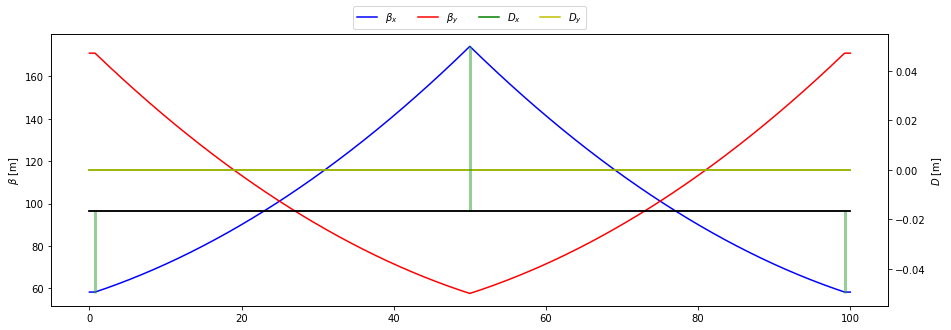

In [6]:
%matplotlib inline

def PLOTFODO(twiss,title=''):
    # Plotting beta function
    #---------------------------    
    plt.figure(figsize=(15,5))
    plt.title(title,loc='left')
    axLeft = plt.gca()
    h1, = plt.plot(twiss['s'],twiss['betx'],'b-',label=r'$\beta_x$')
    h2, = plt.plot(twiss['s'],twiss['bety'],'r-',label=r'$\beta_y$')
    plt.ylabel(r'$\beta$ [m]')

    axRight = plt.twinx()
    h3, = plt.plot(twiss['s'],twiss['dx'],'g-',label=r'$D_x$')
    h4, = plt.plot(twiss['s'],twiss['dy'],'y-',label=r'$D_y$')
    plt.legend(handles=[h1,h2,h3,h4],ncol=4,loc='upper center', bbox_to_anchor=(0.5, 1.12))
    plt.ylabel(r'$D$ [m]')

    plt.xlabel('s [m]')


    # Adding Quad strength
    #--------------------------- 
    axOff = axLeft.twinx()
    plt.plot(twiss['s'],0*twiss['s'],'k')
    plotElements(twiss,ax=axOff)
    axOff.axis('off')
    #plt.ylim([-0.01,0.01])

madDict = { 'sequence': 'FODO',
                'L_cell' : 100,
                'L_Q' : 3,
                'K_Q' : 1/(100/2)/3,
                'Energy' : 7000,
                'Emittance_n' : 2.5e-6,
                'BCurrent':200/2,
                'mux':1/6,
                'muy':1/6}    

mad = MAKEFODO(madDict)
mad.input('survey,sequence=FODO;')
mad.input('twiss;')
survey = mad.table['survey'].dframe()
twiss = mad.table['twiss'].dframe()
PLOTFODO(twiss)

# Wire in FODO cell

In [30]:



# CREATING OUR THREE INSTANCES OF WIRES TO INSTALL

I_w = 200
madDict = { 'sequence': 'FODO',
                'L_cell' : 100,
                'L_Q' : 3,
                'K_Q' : 1/(100/2)/3,
                'Energy' : 7000,
                'Emittance_n' : 2.5e-6,
                'BCurrent':I_w/2,
                'mux':1/6,
                'muy':1/6}



# BEAM-BEAM WIRE
noWire = pd.DataFrame({'mode':['install'],
                             'name':['NoWire'],
                             'at': [madDict['L_cell']/2+5],
                             'definition':['class_noWire : drift, l=0;']})


# MULITPOLE WIRE
multipoleWire = makeMadWire(name = 'multipoleWire',
                        I = I_w,
                        L = 1,
                        pos = [8e-3,0],
                        nmax=20,
                        at = madDict['L_cell']/2+5,
                        p0c = madDict['Energy']*1e9)



# BEAM-BEAM WIRE
BBWire = pd.DataFrame({'mode':['install'],
                             'name':['BBWire'],
                             'at': [madDict['L_cell']/2+5],
                             'definition':['class_BBWire : beambeam, '\
                                            'charge = -1,'\
                                            'xma = 8e-3, yma = 0,'\
                                            'sigx = 200e-6, sigy = 200e-6,'\
                                            'width=0.1,'\
                                            'BBDIR = -1;']})
# WIRE ELEMENT FROM TOBIAS
tobiasWire = pd.DataFrame({'mode':['install'],
                             'name':['tobiasWire'],
                             'at': [madDict['L_cell']/2+5],
                             'definition':[f'class_tobiasWire : wire, current = {I_w}, L = 0, L_phy = 1, L_int = 1, Xma = -8e-3, Yma = 0e-3;']})



Headers:
    NAME: TWISS
    TYPE: TWISS
    SEQUENCE: FODO
    ...
    ORIGIN: 5.07.00 Linux 64
    DATE: 09/10/21
    TIME: 00.28.49

       name    x        betx      alfx
552  nowire  0.0  157.231515  1.634884

Headers:
    NAME: TWISS
    TYPE: TWISS
    SEQUENCE: FODO
    ...
    ORIGIN: 5.07.00 Linux 64
    DATE: 09/10/21
    TIME: 00.28.50

                   name         x        betx      alfx
552  multipolewire_2of2  0.000029  157.209771  1.638732
553  multipolewire_1of2  0.000029  157.209771  1.634493

Headers:
    NAME: TWISS
    TYPE: TWISS
    SEQUENCE: FODO
    ...
    ORIGIN: 5.07.00 Linux 64
    DATE: 09/10/21
    TIME: 00.28.52

       name         x        betx      alfx
552  bbwire  0.001379  155.455799  1.605447

Headers:
    NAME: TWISS
    TYPE: TWISS
    SEQUENCE: FODO
    ...
    ORIGIN: 5.07.00 Linux 64
    DATE: 09/10/21
    TIME: 00.28.53

           name         x        betx      alfx
552  tobiaswire  0.000029  157.209985  1.634498

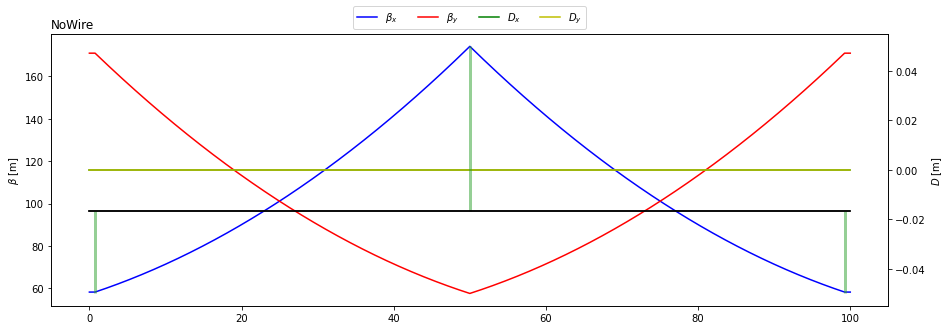

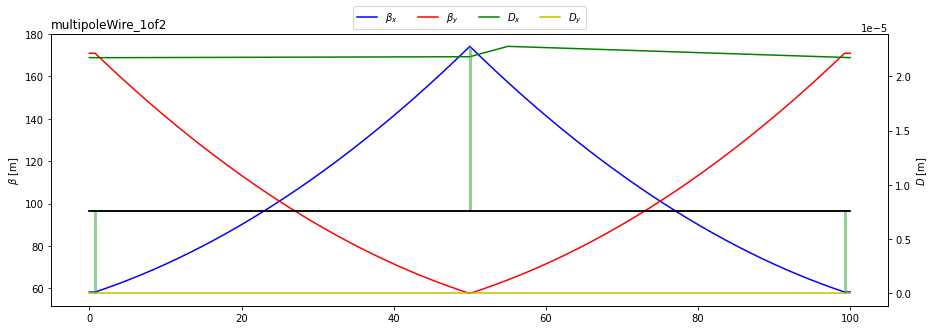

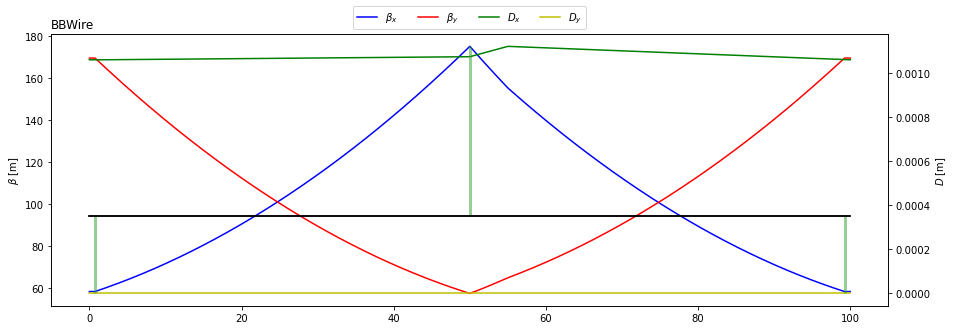

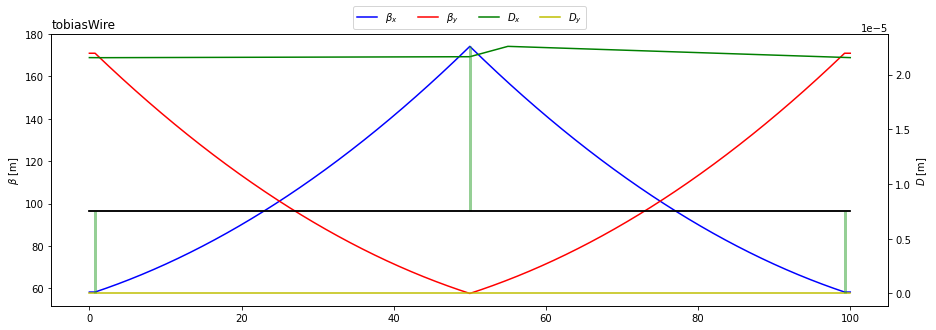

In [31]:



for toInstall in [noWire,multipoleWire,BBWire,tobiasWire]:
    
    MADFile = "tmp_my_log.madlog"
    
    mad = MAKEFODO(madDict)
    mad.input('option, bborbit=True')
    mad.input(seqedit(sequence = 'FODO',editing = toInstall,makeThin=True))
    mad.input(madMatch.format(**madDict))   
    
    # Running with other MADX-Tobias
    mad.input('twiss,file=thisTwiss;')   
    subprocess.call(f'/afs/cern.ch/user/t/tpersson/public/for_Guido/madx_forGuido {MADFile}', shell=True,stdout=subprocess.DEVNULL,stderr=subprocess.STDOUT)
    twiss = tfs.read("thistwiss")
    twiss.columns = list(twiss.columns.str.lower())
    twiss.name = twiss.name.str.lower()
    twiss.keyword = twiss.keyword.str.lower()
    
    #twiss = mad.table['twiss'].dframe()
    display(twiss[twiss['name'].str.contains('wire')][['name','x','betx','alfx']])
    
    PLOTFODO(twiss,title = toInstall.iloc[0]['name'])

name    x        betx      alfx
nowire  nowire:1  0.0  157.237401  1.634937

name         x        betx      alfx
multipolewire_2of2  multipolewire_2of2:1  0.000029  157.210877  1.638769
multipolewire_1of2  multipolewire_1of2:1  0.000029  157.210877  1.634530

name         x        betx      alfx
bbwire  bbwire:1  0.001379  155.438839  1.605453

name    x        betx      alfx
tobiaswire  tobiaswire:1  0.0  157.237401  1.634937

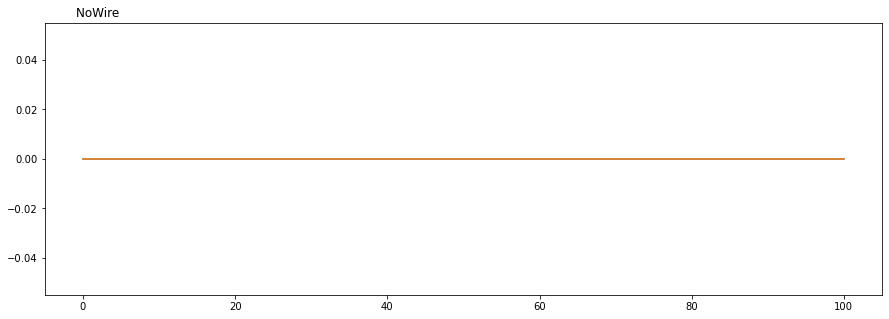

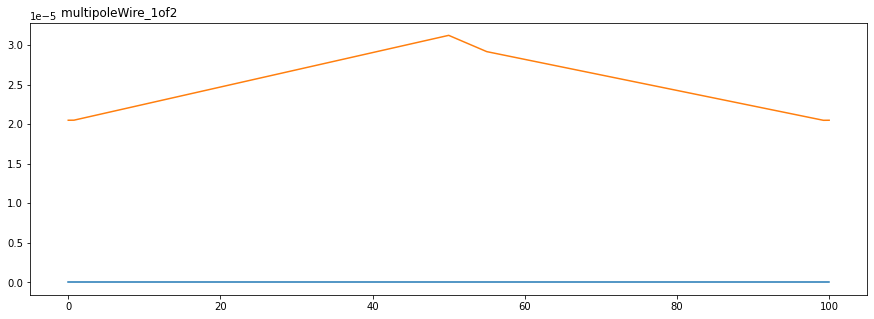

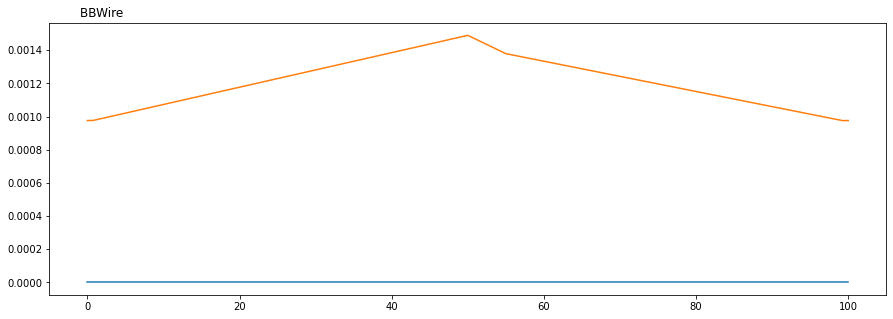

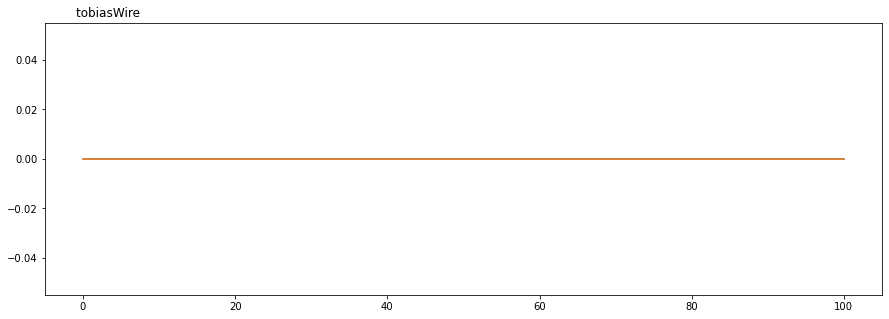

In [183]:
for toInstall in [noWire,multipoleWire,BBWire,tobiasWire]:
    mad = MAKEFODO(200)
    
    mad.input('option, bborbit=True')
    mad.input(seqedit(sequence = 'FODO',editing = toInstall,makeThin=True))
    
    mad.input(madMatch.format(**madDict))
    mad.input('survey,sequence=FODO;')
    mad.input('twiss;')
    survey = mad.table['survey'].dframe()
    twiss = mad.table['twiss'].dframe()
    display(twiss[twiss['name'].str.contains('wire')][['name','x','betx','alfx']])
    
    plt.figure(figsize=(15,5))
    plt.title(8*' ' + toInstall.iloc[0]['name'],loc='left')
    plt.plot(survey['z'],survey['x'])
    plt.plot(twiss['s'],twiss['x'])

name    x        betx      alfx
nowire  nowire:1  0.0  157.237401  1.634937

name         x        betx      alfx
multipolewire_2of2  multipolewire_2of2:1  0.000029  157.210877  1.638769
multipolewire_1of2  multipolewire_1of2:1  0.000029  157.210877  1.634530

name         x        betx      alfx
bbwire  bbwire:1  0.001379  155.438839  1.605453

name    x        betx      alfx
tobiaswire  tobiaswire:1  0.0  157.237401  1.634937

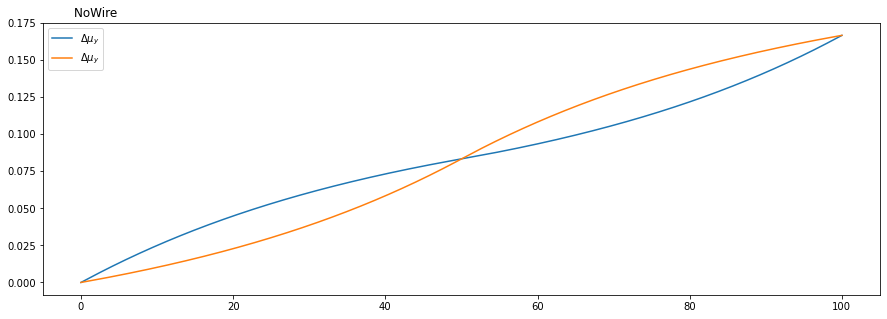

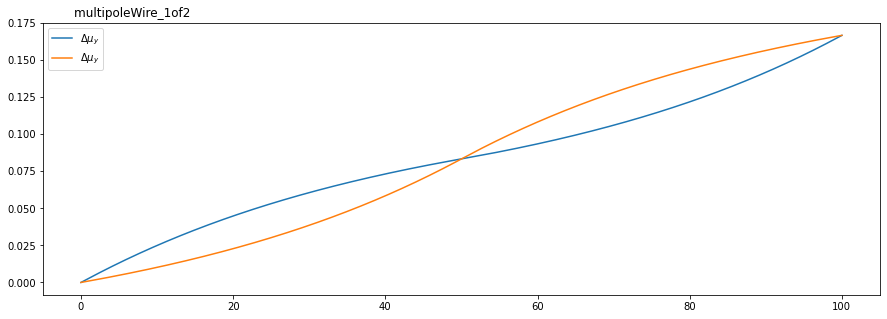

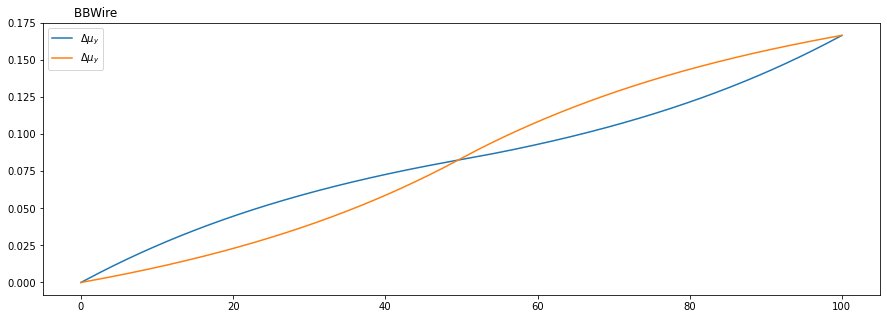

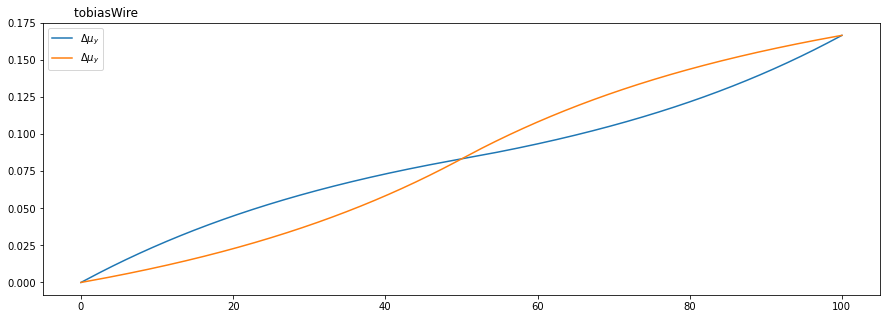

In [227]:

base_mux,base_muy = 0,0
for toInstall in [noWire,multipoleWire,BBWire,tobiasWire]:
    mad = MAKEFODO(200)
    
    mad.input('option, bborbit=True')
    mad.input(seqedit(sequence = 'FODO',editing = toInstall,makeThin=True))
    
    mad.input(madMatch.format(**madDict))
    mad.input('survey,sequence=FODO;')
    mad.input('twiss;')
    survey = mad.table['survey'].dframe()
    twiss = mad.table['twiss'].dframe()
    display(twiss[twiss['name'].str.contains('wire')][['name','x','betx','alfx']])
    
    plt.figure(figsize=(15,5))
    plt.title(8*' ' + toInstall.iloc[0]['name'],loc='left')
    plt.plot(twiss['s'],twiss['mux'],label=r'$\Delta\mu_y$')
    plt.plot(twiss['s'],twiss['muy'],label=r'$\Delta\mu_y$')
    plt.legend()

In [206]:
len(base_mux)

1004

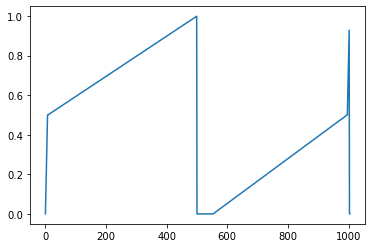

In [213]:
plt.plot(np.mod(np.array(twiss['s'])*10,1))

In [216]:
twiss

name keyword           s       betx      alfx       mux  \
#s          fodo$start:1  marker    0.000000  58.276424 -0.000148  0.000000   
drift_0[0]     drift_0:0   drift    0.107143  58.276652 -0.001986  0.000293   
drift_0[0]     drift_0:0   drift    0.214286  58.277275 -0.003825  0.000585   
drift_0[0]     drift_0:0   drift    0.321429  58.278291 -0.005663  0.000878   
drift_0[0]     drift_0:0   drift    0.428571  58.279702 -0.007502  0.001170   
...                  ...     ...         ...        ...       ...       ...   
drift_4[0]     drift_4:0   drift   99.678571  58.278101  0.005368  0.165789   
drift_4[0]     drift_4:0   drift   99.785714  58.277148  0.003529  0.166082   
drift_4[0]     drift_4:0   drift   99.892857  58.276589  0.001691  0.166375   
drift_4[0]     drift_4:0   drift  100.000000  58.276424 -0.000148  0.166667   
#e            fodo$end:1  marker  100.000000  58.276424 -0.000148  0.166667   

                  bety      alfy       muy        x  ...  sig54         sig55  \
#s          170.925757  0.000164  0.000000  0.00002  ...    0.0  0.000000e+00   
drift_0[0]  170.925789 -0.000463  0.000100  0.00002  ...    0.0  7.510136e-30   
drift_0[0]  170.925956 -0.001090  0.000200  0.00002  ...    0.0  3.004054e-29   
drift_0[0]  170.926257 -0.001717  0.000299  0.00002  ...    0.0  6.759122e-29   
drift_0[0]  170.926692 -0.002344  0.000399  0.00002  ...    0.0  1.201622e-28   
...                ...       ...       ...      ...  ...    ...           ...   
drift_4[0]  170.926467  0.002044  0.166375  0.00002  ...    0.0  2.716307e-21   
drift_4[0]  170.926096  0.001417  0.166475  0.00002  ...    0.0  2.716164e-21   
drift_4[0]  170.925859  0.000790  0.166575  0.00002  ...    0.0  2.716022e-21   
drift_4[0]  170.925757  0.000164  0.166675  0.00002  ...    0.0  2.715879e-21   
#e          170.925757  0.000164  0.166675  0.00002  ...    0.0  2.715879e-21   

            sig56  sig61  sig62  sig63  sig64  sig65  sig66   n1  
#s            0.0    0.0    0.0    0.0    0.0    0.0    0.0  0.0  
drift_0[0]    0.0    0.0    0.0    0.0    0.0    0.0    0.0  0.0  
drift_0[0]    0.0    0.0    0.0    0.0    0.0    0.0    0.0  0.0  
drift_0[0]    0.0    0.0    0.0    0.0    0.0    0.0    0.0  0.0  
drift_0[0]    0.0    0.0    0.0    0.0    0.0    0.0    0.0  0.0  
...           ...    ...    ...    ...    ...    ...    ...  ...  
drift_4[0]    0.0    0.0    0.0    0.0    0.0    0.0    0.0  0.0  
drift_4[0]    0.0    0.0    0.0    0.0    0.0    0.0    0.0  0.0  
drift_4[0]    0.0    0.0    0.0    0.0    0.0    0.0    0.0  0.0  
drift_4[0]    0.0    0.0    0.0    0.0    0.0    0.0    0.0  0.0  
#e            0.0    0.0    0.0    0.0    0.0    0.0    0.0  0.0  

[1005 rows x 256 columns]